<a href="https://colab.research.google.com/github/quirogaez/capstone/blob/main/notebooks/03_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **03_EDA – Procesamiento Final de Imágenes: Balanceo de Clases**

## Importación y cargue de imágenes

Importar librerías

In [9]:
import os
import cv2
import glob
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from collections import Counter

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Llamar los archivos

In [11]:
# Cargar imágenes
img_train = '/content/drive/MyDrive/Capstone/data/multiclass/train'
# img_vali = '/content/drive/MyDrive/Capstone/data/multiclass/val'
# img_test = '/content/drive/MyDrive/Capstone/data/multiclass/test'

# Ver archivos en la carpeta
df_train = os.listdir(img_train)
# df_vali = os.listdir(img_vali)
# df_test = os.listdir(img_test)

Cargar datasets

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_train, # Entrenamiento
    batch_size = 32,
    label_mode = 'categorical'
)
class_names = train_ds.class_names

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     img_test, # Testeo
#     batch_size = 32,
#     label_mode = 'categorical'
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     img_vali, # Validación
#     batch_size = 32,
#     label_mode = 'categorical'
# )

Found 5638 files belonging to 3 classes.


## *Oversampling*

*Oversampling* de la clase minoritaria (`NORMAL`) para igualarla a la cantidad de imágenes de la clase intermedia (`PNEUMONIA-VIRAL`).


Calcular cuántas imágenes se deben generar

In [13]:
target_size = len(viral_imgs)
current_size = len(normal_imgs)
images_to_generate = target_size - current_size

print(f"Se necesita generar {images_to_generate} imágenes nuevas para NORMAL.")

Se necesita generar 0 imágenes nuevas para NORMAL.


Configurar *Data Augmentation*

In [14]:
# Librerías necesarias
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import shutil

In [15]:
# Directorio temporal para guardar las imágenes aumentadas
augmented_dir = '/content/drive/MyDrive/Capstone/data/multiclass/train/NORMAL_augmented'
os.makedirs(augmented_dir, exist_ok = True)

In [16]:
# Configurar el generador de imágenes con augmentations variados
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.10,
    height_shift_range = 0.10,
    shear_range = 0.10,
    zoom_range = 0.10,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

Generar imágenes aumentadas

In [17]:
generated_count = 0

for img_path in normal_imgs:
    if generated_count >= images_to_generate:
        break

    # Cargar imagen y convertir a array
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Crear iterador de augmentations
    aug_iter = datagen.flow(x, batch_size = 1)

    # Generar una imagen por cada iteración
    for _ in range(1):  # Solo 1 augmentación por imagen original
        aug_img = next(aug_iter)[0].astype('uint8')
        aug_img_pil = array_to_img(aug_img)

        # Guardar imagen aumentada
        save_path = os.path.join(augmented_dir, f'aug_{generated_count}.jpg')
        aug_img_pil.save(save_path)

        generated_count += 1

        if generated_count >= images_to_generate:
            break

print(f"Imágenes aumentadas generadas: {generated_count}")

Imágenes aumentadas generadas: 0


Mover las imágenes aumentadas a la carpeta de `NORMAL` para el cargue



In [18]:
# Ruta actual de las imágenes aumentadas
augmented_dir = '/content/drive/MyDrive/Capstone/data/multiclass/train/NORMAL_augmented'

# Ruta destino: carpeta de la clase NORMAL
normal_dir = '/content/drive/MyDrive/Capstone/data/multiclass/train/NORMAL'

# Mover todas las imágenes aumentadas a la carpeta NORMAL
augmented_images = os.listdir(augmented_dir)

for img_file in augmented_images:
    src_path = os.path.join(augmented_dir, img_file)
    dest_path = os.path.join(normal_dir, img_file)
    shutil.move(src_path, dest_path)

# Eliminar la carpeta vacía NORMAL_augmented
shutil.rmtree(augmented_dir)

Recargar el dataset las imágenes aumentadas

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_train,  # Carpeta raíz de entrenamiento
    batch_size=32,
    label_mode='categorical'
)
class_names = train_ds.class_names; class_names

Found 5638 files belonging to 3 classes.


['NORMAL', 'PNEUMONIA-BACTERIAL', 'PNEUMONIA-VIRAL']

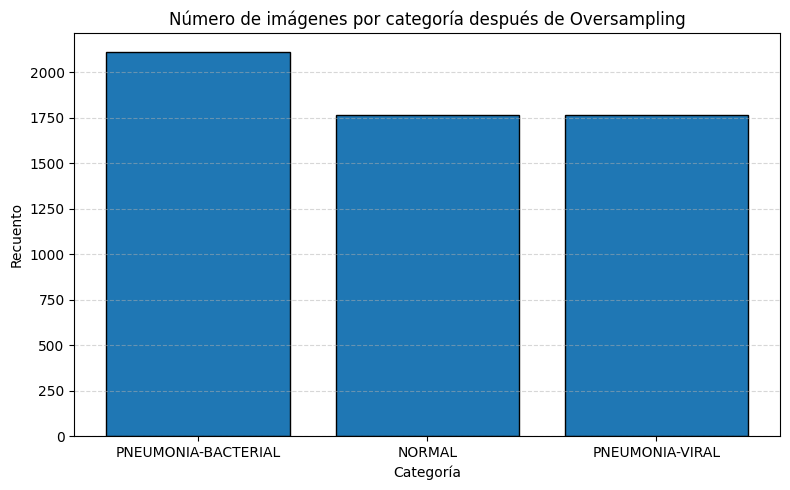

In [20]:
# Crear etiquetas a partir del dataset cargado
labels = []

for _, label in train_ds.unbatch():
    labels.append(tf.argmax(label).numpy())

# Contar las categorías
label_counts = Counter(labels)

# Convertir a DataFrame
counts_df_plot = pd.DataFrame({
    'Categoría': [class_names[idx] for idx in label_counts.keys()],
    'Recuento': list(label_counts.values())
})

# Visualización con el mismo estilo
plt.figure(figsize = (8, 5))
plt.bar(
    counts_df_plot['Categoría'],
    counts_df_plot['Recuento'],
    edgecolor = 'black'
)
plt.title("Número de imágenes por categoría después de Oversampling")
plt.xlabel("Categoría")
plt.ylabel("Recuento")
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

## *Undersampling*


*Undersampling* de la clase mayoritaria (`PNEUMONIA-BACTERIAL`) para igualarla a la cantidad de imágenes de la clase intermedia (`PNEUMONIA-VIRAL`).


Crear DataFrame con las rutas de las imágenes

In [21]:
# Crear listas de rutas por clase
bacterial_path = os.path.join(img_train, 'PNEUMONIA-BACTERIAL', '*')
viral_path = os.path.join(img_train, 'PNEUMONIA-VIRAL', '*')
normal_path = os.path.join(img_train, 'NORMAL', '*')

bacterial_imgs = glob.glob(bacterial_path)
viral_imgs = glob.glob(viral_path)
normal_imgs = glob.glob(normal_path)

print(f'Bacterial: {len(bacterial_imgs)}')
print(f'Viral: {len(viral_imgs)}')
print(f'Normal: {len(normal_imgs)}')

Bacterial: 2110
Viral: 1764
Normal: 1764


Hacer Undersampling de la clase mayoritaria

In [22]:
# Establecer el tamaño objetivo
target_size = len(viral_imgs)

# Hacer undersampling aleatorio
bacterial_imgs_sampled = random.sample(bacterial_imgs, target_size)

# Confirmar
print(f'Bacterial después de undersampling: {len(bacterial_imgs_sampled)}')

Bacterial después de undersampling: 1764


Crear un dataset balanceado

In [23]:
# Crear lista total de imágenes balanceadas
balanced_image_paths = bacterial_imgs_sampled + viral_imgs + normal_imgs

# Mezclar aleatoriamente
random.shuffle(balanced_image_paths)

print(f'Total de imágenes balanceadas: {len(balanced_image_paths)}')

Total de imágenes balanceadas: 5292


Visualizar la nueva distribución

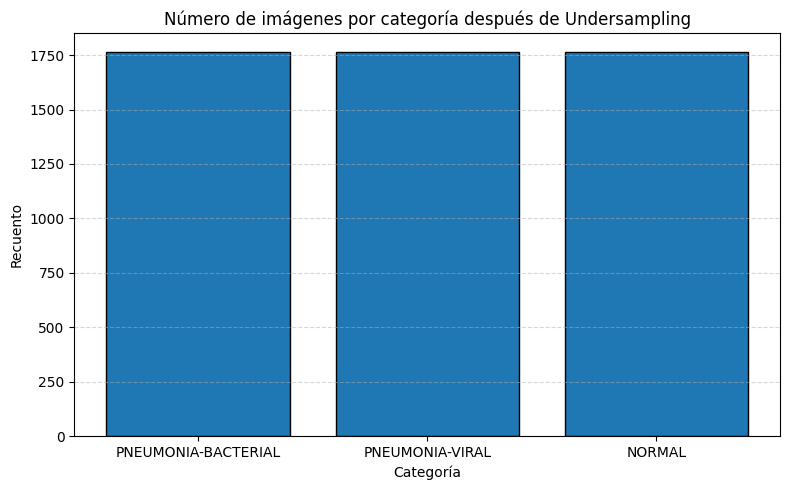

In [24]:
# Crear etiquetas a partir de las rutas
labels = []
for path in balanced_image_paths:
    if 'PNEUMONIA-BACTERIAL' in path:
        labels.append('PNEUMONIA-BACTERIAL')
    elif 'PNEUMONIA-VIRAL' in path:
        labels.append('PNEUMONIA-VIRAL')
    else:
        labels.append('NORMAL')

# Contar las categorías
label_counts = Counter(labels)

# Convertir a DataFrame
counts_df_plot = pd.DataFrame({
    'Categoría': list(label_counts.keys()),
    'Recuento': list(label_counts.values())
})

# Visualización
plt.figure(figsize = (8, 5))
plt.bar(
    counts_df_plot['Categoría'],
    counts_df_plot['Recuento'],
    edgecolor = 'black'
)
plt.title("Número de imágenes por categoría después de Undersampling")
plt.xlabel("Categoría")
plt.ylabel("Recuento")
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

Eliminar las imágenes descartadas en el `urdersampling`

In [25]:
# Calcular las imágenes que no quedaron en el undersampling
bacterial_imgs_to_delete = list(set(bacterial_imgs) - set(bacterial_imgs_sampled))

print(f"Cantidad de imágenes que se van a eliminar: {len(bacterial_imgs_to_delete)}")

Cantidad de imágenes que se van a eliminar: 346


In [26]:
# Eliminar las imágenes descartadas
for img_path in bacterial_imgs_to_delete:
    os.remove(img_path)

In [27]:
# Recargar el dataset balanceado directamente desde la carpeta original
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_train,
    batch_size = 32,
    label_mode = 'categorical'
)

class_names = train_ds.class_names; class_names

Found 5292 files belonging to 3 classes.


['NORMAL', 'PNEUMONIA-BACTERIAL', 'PNEUMONIA-VIRAL']

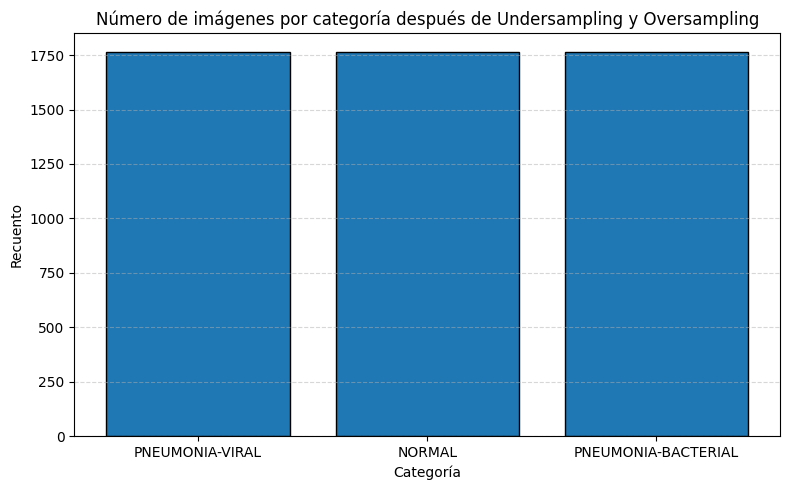

In [28]:
labels = []

for _, label in train_ds.unbatch():
    labels.append(tf.argmax(label).numpy())

label_counts = Counter(labels)

counts_df_plot = pd.DataFrame({
    'Categoría': [class_names[idx] for idx in label_counts.keys()],
    'Recuento': list(label_counts.values())
})

plt.figure(figsize=(8, 5))
plt.bar(
    counts_df_plot['Categoría'],
    counts_df_plot['Recuento'],
    edgecolor = 'black'
)
plt.title("Número de imágenes por categoría después de Undersampling y Oversampling")
plt.xlabel("Categoría")
plt.ylabel("Recuento")
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()